In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import sklearn
from sklearn import datasets
import torch
import cvxopt
import pyomo.environ as pe

# Visualization code

In [3]:
def draw_contour(ax, f, xlow, xhigh, ylow, yhigh):
    x,y = np.meshgrid(np.arange(xlow, xhigh, 0.1), np.arange(ylow, yhigh, 0.1))
    #Slow loop
    z = np.zeros(np.shape(x))
    for i in np.arange(0, np.shape(x)[0]):
        for j in np.arange(0, np.shape(x)[1]):
            z[i,j] = f(np.array((x[i,j],y[i,j])))
    ax.contour(x,y,z, levels=10, alpha=0.2)
    
def draw_search_path(ax, steps):
    linecoll = mpl.collections.LineCollection(zip(steps[:-1], steps[1:]), colors='r')
    linecoll.set_linestyle('-')
    ax.add_collection(linecoll)
    ax.scatter(steps[0][0], steps[0][1], marker='s', c='r') #Start point
    ax.scatter(steps[-1][0], steps[-1][1], marker='*', c='b') #End point
    ax.scatter([pos[0] for pos in steps[1:-1]], [pos[1] for pos in steps[1:-1]], marker='.', c = 'r') #Middle points


def illustrate_search(ax, f, steps, xlow, xhigh, ylow, yhigh):
    print("Iteration sequence:")
    print(steps)
    draw_contour(ax, f, xlow, xhigh, ylow, yhigh)
    draw_search_path(ax, steps)

In [4]:
class QuadraticObjective(object):
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def value(self, p):
        return 0.5 * np.dot(p, np.dot(self.a, p)) + np.dot(self.b, p) + self.c
    
    def grad(self, p):
        return np.dot(self.a, p) + self.b
    
    def hess(self, p):
        return self.a

Algorithms
=========

In [5]:
def fake_algorithm():
    return [[-2,0],[-1,-1],[3,-1]]

Algorithm tests
==============

In [6]:
simple_quad_obj = QuadraticObjective(np.eye(2), np.array([-2.0, 4.0]), 5.0)
stretched_quad_obj = QuadraticObjective(np.array([[10.0,-1.0],[-1.0, 2.0]]), np.array([3.0, 3.0]), 2.0)

Iteration sequence:
[[-2, 0], [-1, -1], [3, -1]]


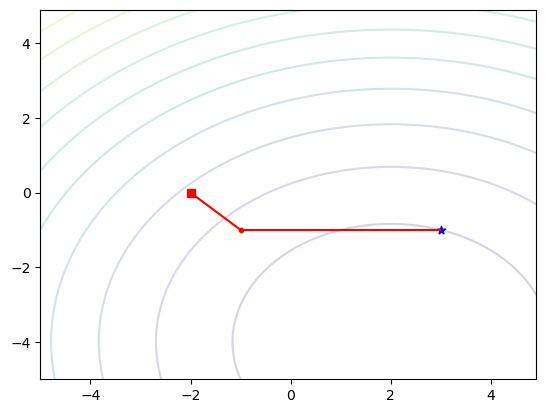

In [7]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, fake_algorithm(), -5, 5, -5, 5)
plt.draw()
plt.show()

Iteration sequence:
[[-2, 0], [-1, -1], [3, -1]]


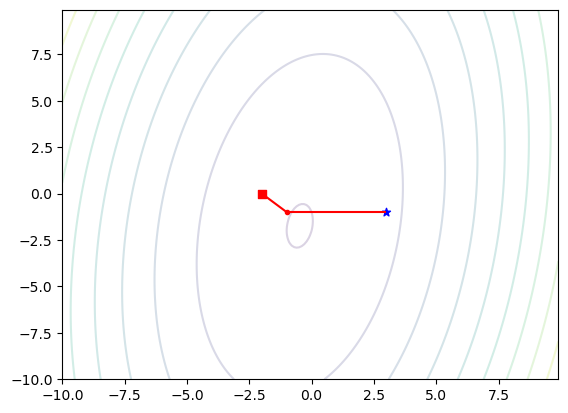

In [8]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, fake_algorithm(), -10, 10, -10, 10)
plt.draw()
plt.show()

# Gradient descent and Newton's Method

In [9]:
def simple_stop_crit(points, step_dir, tolerance = 1e-2):
    return np.linalg.norm(step_dir) <= tolerance

def backtracking(f, grad, x, d, init_step = 1.0, dec = 0.1, contraction=0.4):
    orig_val = f(x)
    orig_grad = grad(x)
    step = init_step
    while f(x  + step * d) > orig_val + dec * step * np.dot(orig_grad, d):
        step *= contraction
        if step < 1e-20:
            raise 'Backtracking failed'
    return step


def descent_method(x_init, dir_finder, size_finder, stop_crit):
    points = [x_init]
    cont = True
    
    x = x_init
    while cont:
        step_dir = dir_finder(x)
        if stop_crit(points, step_dir):
            cont = False
        step_size = size_finder(x, step_dir)
        x = x + step_size*step_dir
        
        points.append(x)

    return points

def steepest_descent(f, grad, x_0):
    return descent_method(x_0,
                          lambda x : -grad(x),
                          lambda x, d : backtracking(f, grad, x, d),
                          lambda ps, x: simple_stop_crit(ps, x))

def newton(f, grad, hess, x_0):
    return descent_method(x_0,
                          lambda x : -np.linalg.solve(hess(x), grad(x)),
                          lambda x, d : backtracking(f, grad, x, d),
                          lambda ps, x: simple_stop_crit(ps, x))

### Steepest Descent

Iteration sequence:
[array([-2.,  0.]), array([ 2., -4.]), array([ 2., -4.])]


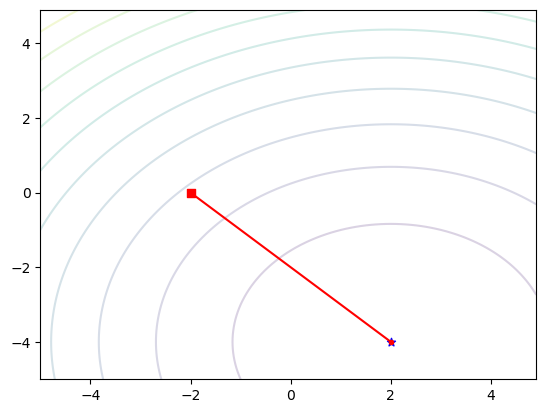

In [10]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, 
                  steepest_descent(simple_quad_obj.value, simple_quad_obj.grad, np.array([-2.0,0.0])),
                  -5, 5, -5, 5)

Iteration sequence:
[array([-2.,  4.]), array([1.36, 1.92]), array([-0.9888,  1.0432]), array([0.280192, 0.071168]), array([-0.63672832, -0.38677504]), array([-0.15984701, -0.84488356]), array([-0.51927316, -1.08009634]), array([-0.34125152, -1.29754922]), array([-0.48285696, -1.41693371]), array([-0.41699522, -1.52077204]), array([-0.4731264 , -1.58084422]), array([-0.4129585, -1.7054194]), array([-0.50509201, -1.70575855]), array([-0.44986617, -1.72073054]), array([-0.48539719, -1.72207535]), array([-0.46429374, -1.72867479]), array([-0.47801172, -1.72978586]), array([-0.46995871, -1.73273626]), array([-0.47526258, -1.73345405]), array([-0.4721951 , -1.73479076]), array([-0.47424946, -1.73520894]), array([-0.47308375, -1.73582199])]


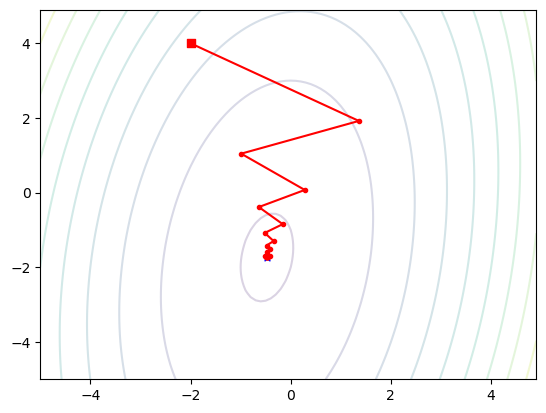

In [11]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, 
                  steepest_descent(stretched_quad_obj.value, stretched_quad_obj.grad, np.array([-2.0,4.0])),
                  -5, 5, -5, 5)

Iteration sequence:
[array([-2.,  4.]), array([0.1, 2.7]), array([-0.082,  1.538]), array([-0.19268,  0.54308]), array([-0.2854888, -0.2076056]), array([-0.35078798, -0.7385651 ]), array([-0.39509489, -1.09844989]), array([-0.42424038, -1.33520481]), array([-0.44299068, -1.48751528]), array([-0.45484395, -1.58380065]), array([-0.46223148, -1.64381037]), array([-0.46678143, -1.68077005]), array([-0.46955539, -1.70330328]), array([-0.47123166, -1.71691976]), array([-0.47223663, -1.72508329]), array([-0.47283487, -1.72994283]), array([-0.47318866, -1.73281673]), array([-0.47339663, -1.73450605]), array([-0.47351818, -1.73549341]), array([-0.47358883, -1.73606736]), array([-0.47362969, -1.73639926]), array([-0.4736532 , -1.73659022]), array([-0.47366666, -1.73669954]), array([-0.47367433, -1.73676182]), array([-0.47367867, -1.73679713]), array([-0.47368112, -1.73681704]), array([-0.4736825 , -1.73682822]), array([-0.47368327, -1.73683445]), array([-0.47368369, -1.73683792]), array([-0.4736

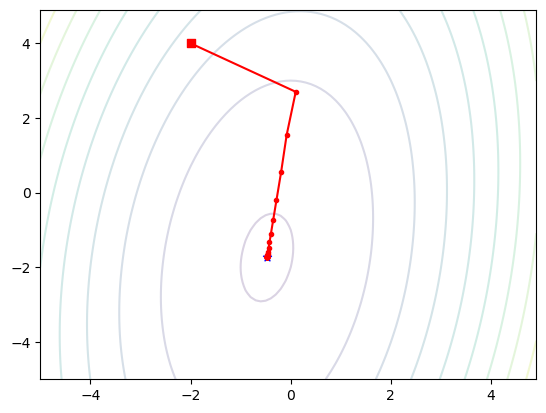

In [12]:
def accelerated_descent(f, grad, x_init, s, mu, change_tol = 1e-3):
    points = [x_init]
    cont = True
    
    x = x_init
    v = np.zeros(len(x))
    while cont:
        v_new = mu*v - s * grad(x + mu*v)
        x = x + v_new
        v = v_new
        points.append(x)
        if len(points) > 30:
            break
        
    return points

fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, 
                  accelerated_descent(stretched_quad_obj.value, stretched_quad_obj.grad, np.array([-2.0,4.0]), 0.1, 0.4),
                  -5, 5, -5, 5)

### Newton

Iteration sequence:
[array([-2.,  0.]), array([ 2., -4.]), array([ 2., -4.])]


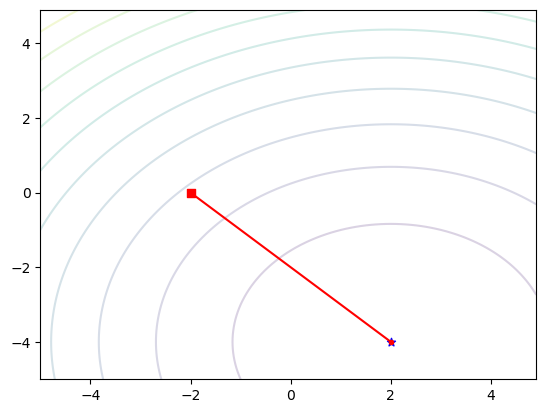

In [13]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, 
                  newton(simple_quad_obj.value, simple_quad_obj.grad, simple_quad_obj.hess, np.array([-2.0,0.0])),
                  -5, 5, -5, 5)

Iteration sequence:
[array([-2.,  4.]), array([-0.47368421, -1.73684211]), array([-0.47368421, -1.73684211])]


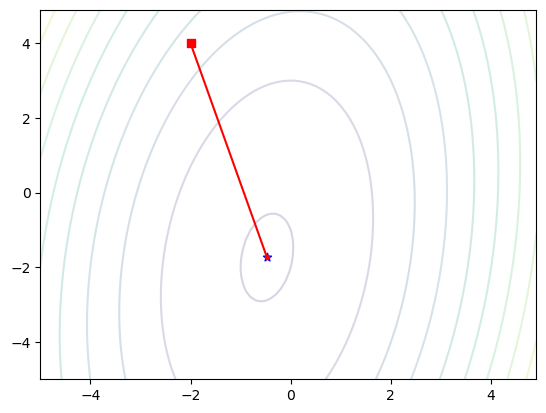

In [14]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, 
                  newton(stretched_quad_obj.value, stretched_quad_obj.grad, stretched_quad_obj.hess, np.array([-2.0,4.0])),
                  -5, 5, -5, 5)

# CVXOPT-SVM

There is an in-built, but we'll do it ourselves this time.

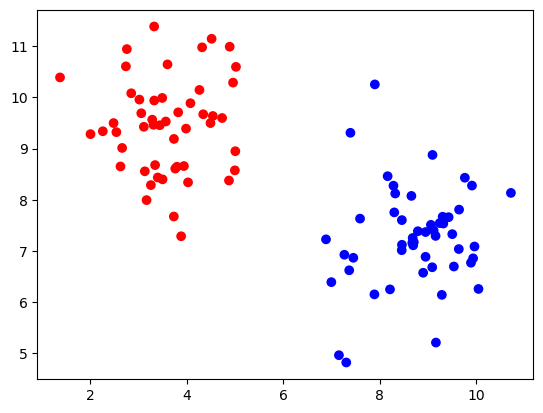

In [45]:
(samples, classifications) = sklearn.datasets.make_blobs(centers=2)
classifications = np.array([2 * float(c) - 1 for c in classifications]) #Map (0,1) to (-1,1)
plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])

     pcost       dcost       gap    pres   dres
 0:  3.3714e-02  5.6855e+00  4e+02  2e+00  4e+02
 1:  1.3741e+00 -5.3226e+00  7e+00  3e-02  6e+00
 2:  7.6964e-01 -4.6693e-01  1e+00  4e-03  7e-01
 3:  1.9811e-01 -7.9896e-02  3e-01  8e-04  2e-01
 4:  7.5383e-02 -2.7620e-02  1e-01  3e-04  5e-02
 5:  6.1982e-03  1.9384e-03  4e-03  7e-16  9e-17
 6:  4.6814e-03  3.8649e-03  8e-04  6e-16  9e-17
 7:  4.3214e-03  4.2899e-03  3e-05  6e-16  5e-16
 8:  4.3052e-03  4.3049e-03  3e-07  6e-16  3e-16
 9:  4.3050e-03  4.3050e-03  3e-09  7e-16  8e-17
Optimal solution found.


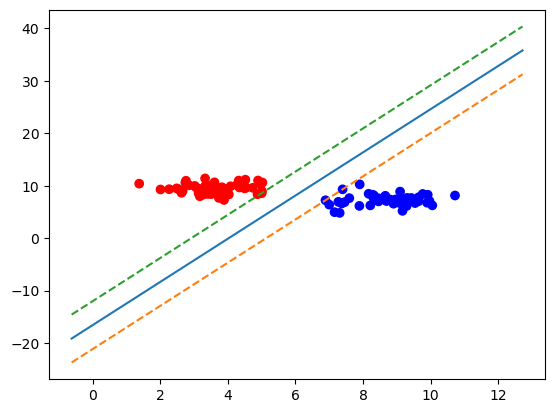

In [56]:
import cvxopt

def do_svm_primal(samples, classifications, mu=1.0):
    #As shown on the board we'll build the matrices we need
    var_len = 3 + len(samples)
    
    # Make objective
    p = np.zeros((var_len, var_len))
    p[0,0] = mu
    p[1,1] = mu
    q = np.zeros(var_len)
    q[3:] = 1.0/len(samples)
    
    # First part of the inequalities - nonnegativity
    upper_g = np.zeros((len(samples), var_len))
    upper_g[:,3:] = - np.eye(len(samples))
    
    # Second part - classification
    lower_g = np.copy(upper_g) #Last bit has same structure
    lower_g[:,0] = -classifications * samples[:,0]
    lower_g[:,1] = -classifications * samples[:,1]
    lower_g[:,2] = np.copy(classifications)
    
    g = np.vstack((upper_g, lower_g))
    h = np.hstack((np.zeros(len(samples)), -np.ones(len(samples))))
    
    # Now let's make the CVX format
    P = cvxopt.matrix(p)
    Q = cvxopt.matrix(q)
    G = cvxopt.matrix(g)
    H = cvxopt.matrix(h)
    
    sol = cvxopt.solvers.qp(P, Q, G, H)
    sol_ar = np.array(sol['x'])
    beta = np.copy(sol_ar[:2])
    alpha = sol_ar[2]
    
    return (beta, alpha)
    
beta, alpha = do_svm_primal(samples, classifications, 0.01)

plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])
xlow = np.min(samples[:,0]) - 2.0
xhigh = np.max(samples[:,0]) + 2.0
if (np.abs(beta[1]) > 1e-3): # or vertical
    xs = np.linspace(xlow, xhigh)
    ys = (alpha - beta[0]*xs)/beta[1]
    plt.plot(xs,ys)
    
    upper_ys = (1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, upper_ys, '--')
    lower_ys = (-1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, lower_ys, '--')
else:
    plt.axvline(alpha/beta[0])

     pcost       dcost       gap    pres   dres
 0: -9.1306e+00 -1.7826e+02  9e+02  2e+00  5e-12
 1: -5.2388e+00 -8.7946e+01  1e+02  3e-01  5e-12
 2: -2.2534e+00 -1.3935e+01  2e+01  4e-02  3e-12
 3: -1.0345e+00 -6.6938e+00  1e+01  2e-02  2e-12
 4: -7.0441e-02 -1.4253e+00  2e+00  3e-03  2e-12
 5:  3.7063e-03 -3.0037e-02  4e-02  3e-05  8e-14
 6: -1.0859e-03 -1.7578e-02  2e-02  1e-05  3e-14
 7: -5.7571e-03 -1.6839e-02  1e-02  5e-06  3e-14
 8: -9.4166e-03 -1.0179e-02  8e-04  3e-07  3e-14
 9: -9.7426e-03 -9.7624e-03  2e-05  6e-09  3e-14
10: -9.7510e-03 -9.7512e-03  2e-07  6e-11  3e-14
11: -9.7511e-03 -9.7511e-03  2e-09  6e-13  3e-14
Optimal solution found.
{'x': <100x1 matrix, tc='d'>, 'y': <0x1 matrix, tc='d'>, 's': <200x1 matrix, tc='d'>, 'z': <200x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.1095546089385077e-09, 'relative gap': 2.1633998212115438e-07, 'primal objective': -0.009751108363118557, 'dual objective': -0.009751110347237116, 'primal infeasibility': 6.291118934944234e-13, 'd

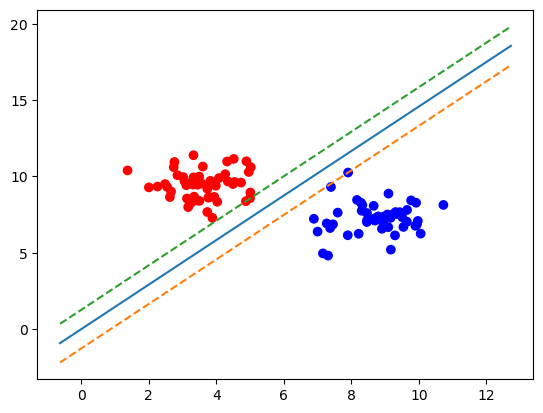

In [54]:
# SVM with limited support

def svm_limited(X, Y, s, gamma):
    # Solve the maximization problem in Bertsimas-Dunn as a QP
    (n, p) = np.shape(X)
    
    # Build objective
    P_np = np.zeros((n, n))
    for j in range(p):
        P_np += gamma * s[j] * np.outer(X[:,j], X[:,j]) # 1/2 comes from cvxopt here
    q_np = Y
    
    P = cvxopt.matrix(P_np)
    q = cvxopt.matrix(q_np)
       
    # Build constraints
    G_np = np.vstack((np.diag(Y), -np.diag(Y)))
    h_np = np.vstack((np.zeros((n,1)), np.ones((n,1))))
    
    G = cvxopt.matrix(G_np)
    h = cvxopt.matrix(h_np)

    sol = cvxopt.solvers.qp(P, q, G, h)#, A, b)
    #print(sol)
    
    sol_ar = np.array(sol['x'])
    # We actually want the dual solution
    print(sol)
    #raise 'Hell'
    
    # Remember to multiply objective by -1!
    #print(grad)
    return  -gamma * np.dot(np.dot(X, np.diag(s)).T, sol_ar)

s = np.array([1,1,0])
X = np.hstack((samples, -np.ones((len(samples),1))))
Y = np.copy(classifications)
sol = svm_limited(X, Y, s, 100.0)
beta = sol[:-1]
alpha = sol[-1]
print(beta)
print(alpha)

plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])
xlow = np.min(samples[:,0]) - 2.0
xhigh = np.max(samples[:,0]) + 2.0
if (np.abs(beta[1]) > 1e-3): # or vertical
    xs = np.linspace(xlow, xhigh)
    ys = (alpha - beta[0]*xs)/beta[1]
    plt.plot(xs,ys)
    
    upper_ys = (1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, upper_ys, '--')
    lower_ys = (-1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, lower_ys, '--')
else:
    plt.axvline(alpha/beta[0])
    
print(Y)

# Simple neural network

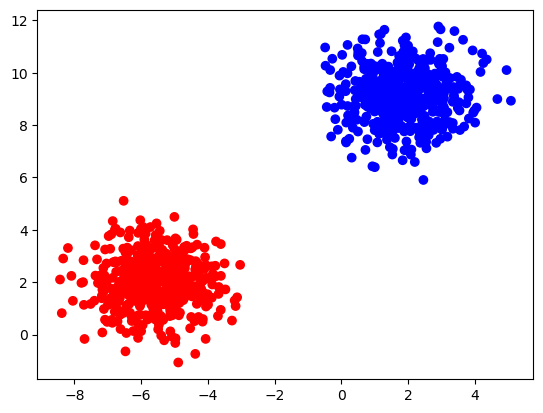

In [57]:
(samples, classifications) = sklearn.datasets.make_blobs(n_samples=1000, centers=2)
plt.scatter(samples[:,0], samples[:,1], c=['red' if c == 0 else 'blue' for c in classifications])

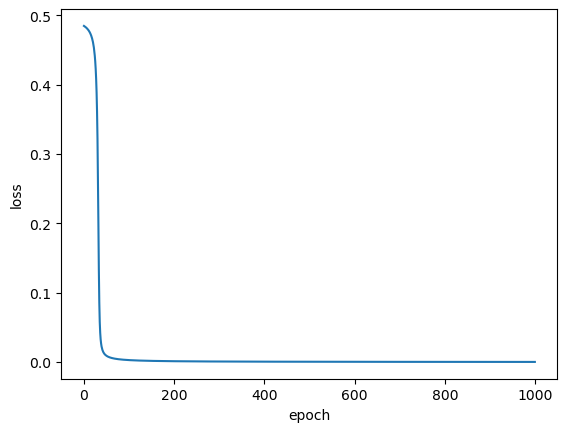

0.0


/tmp/ipykernel_116/3531207503.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(np.sum(np.abs(a - b) for (a,b) in zip(np.round(test_output), classifications[600:])))


In [58]:
#Stupidly simplified

model = torch.nn.Sequential(torch.nn.Linear(2, 1),
                            torch.nn.Sigmoid())
loss = torch.nn.MSELoss()
sgd_opt = torch.optim.SGD(model.parameters(), lr=0.1) #Learning rate should be low, 
# Our friend SGD!!

train_input = torch.tensor(samples[:600,:])
train_output = torch.reshape(torch.tensor(classifications[:600]), (600,1))

losses = []
for epoch in range(1000):
    sgd_opt.zero_grad() #Technical
    
    # Find the objective
    pred_y = model(train_input.float())
    iter_loss = loss(pred_y, train_output.float())
    # Store it
    losses.append(iter_loss.item())
    

    iter_loss.backward() #Find gradients
    
    sgd_opt.step()

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

model.eval()
test_input = torch.tensor(samples[600:,:])
test_output = model(test_input.float()).detach().numpy().flatten()
print(np.sum(np.abs(a - b) for (a,b) in zip(np.round(test_output), classifications[600:])))